# Loan Prediction 

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, 
    roc_curve, auc, mutual_info_score, accuracy_score
)
from sklearn.ensemble import RandomForestClassifier

In [3]:
df = pd.read_csv("loan_data.csv")
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

## EDA

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2,)
df_train, df_val = train_test_split(df_full_train, test_size=0.25,)
len(df_train), len(df_val), len(df_test)

(27000, 9000, 9000)

In [6]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [7]:
y_train = df_train.loan_status.values
y_val = df_val.loan_status.values
y_test = df_test.loan_status.values

In [8]:
del df_train["loan_status"]
del df_val["loan_status"]
del df_test["loan_status"]

In [9]:
cat_cols = [var for var in df.columns if df[var].dtypes == 'object']
num_cols = [var for var in df.columns if df[var].dtypes != 'object']

print(f'Categorical columns: {cat_cols}')
print(f'Numerical columns: {num_cols}')

Categorical columns: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
Numerical columns: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'loan_status']


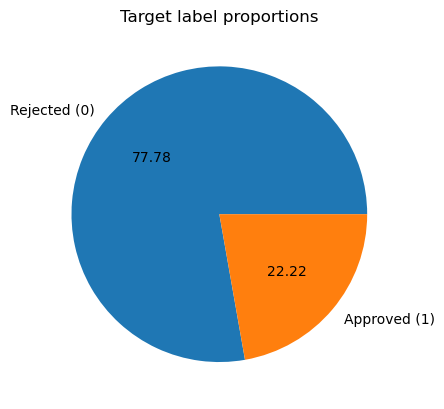

In [10]:
label_prop = df["loan_status"].value_counts()

plt.pie(label_prop.values, labels=["Rejected (0)", "Approved (1)"], autopct="%.2f")
plt.title("Target label proportions")
plt.show()

In [11]:
global_loan_rate = (df_full_train.loan_status.mean())

female_loan = df_full_train[df_full_train.person_gender == "female"].loan_status.mean()
male_loan = df_full_train[df_full_train.person_gender == "male"].loan_status.mean()

print(f" Female Loan rate: {female_loan:.3f}\n Male Loan rate: {male_loan:.3f}\n Global Loan rate:  {global_loan_rate:.3f}")

 Female Loan rate: 0.224
 Male Loan rate: 0.223
 Global Loan rate:  0.223


In [12]:
from IPython.display import display

for c in cat_cols:
    print(c)
    df_group = df_full_train.groupby(c).loan_status.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_loan_rate
    df_group['risk'] = df_group['mean'] / global_loan_rate
    display(df_group)
    print("\n\n")

person_gender


,mean,count,diff,risk
person_gender,,,,
female,0.224037,16167,0.000703,1.003149
male,0.222760,19833,-0.000573,0.997433





person_education


,mean,count,diff,risk
person_education,,,,
Associate,0.219300,9544,-0.004033,0.981941
Bachelor,0.227852,10757,0.004518,1.020231
Doctorate,0.229675,492,0.006341,1.028395
High School,0.224682,9667,0.001349,1.006038
Master,0.218592,5540,-0.004741,0.978770





person_home_ownership


,mean,count,diff,risk
person_home_ownership,,,,
MORTGAGE,0.117440,14765,-0.105893,0.525850
OTHER,0.296703,91,0.073370,1.328522
OWN,0.074916,2376,-0.148418,0.335444
RENT,0.325075,18768,0.101741,1.455558





loan_intent


,mean,count,diff,risk
loan_intent,,,,
DEBTCONSOLIDATION,0.306154,5752,0.082821,1.370841
EDUCATION,0.169450,7306,-0.053884,0.758730
HOMEIMPROVEMENT,0.264426,3778,0.041092,1.183995
MEDICAL,0.280609,6828,0.057276,1.256459
PERSONAL,0.205250,6095,-0.018083,0.919031
VENTURE,0.140202,6241,-0.083131,0.627770





previous_loan_defaults_on_file


,mean,count,diff,risk
previous_loan_defaults_on_file,,,,
No,0.453981,17710,0.230647,2.03275
Yes,0.000000,18290,-0.223333,0.00000


In [13]:
mi = {}
for c in cat_cols:
    mi[c] = mutual_info_score(df_full_train[c], df_full_train.loan_status)

pd.Series(mi).sort_values(ascending=False)

previous_loan_defaults_on_file    0.192191
person_home_ownership             0.034833
loan_intent                       0.010932
person_education                  0.000043
person_gender                     0.000001
dtype: float64

In [14]:
num_cols_for_mi = [c for c in num_cols if c != "loan_status"]
mi_scores = mutual_info_classif(df_full_train[num_cols_for_mi], df_full_train.loan_status)

mi = dict(zip(num_cols_for_mi, mi_scores))
pd.Series(mi).sort_values(ascending=False)

person_income                 0.092251
loan_percent_income           0.082139
loan_int_rate                 0.072933
loan_amnt                     0.017043
person_age                    0.003934
credit_score                  0.002610
person_emp_exp                0.000000
cb_person_cred_hist_length    0.000000
dtype: float64

In [15]:
df_full_train[num_cols].corrwith(df_full_train.loan_status)

person_age                   -0.021684
person_income                -0.126358
person_emp_exp               -0.020147
loan_amnt                     0.108461
loan_int_rate                 0.332170
loan_percent_income           0.381413
cb_person_cred_hist_length   -0.014840
credit_score                 -0.007060
loan_status                   1.000000
dtype: float64

## One hot encoding

In [16]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[cat_cols + num_cols_for_mi].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[cat_cols + num_cols_for_mi].to_dict(orient='records')
X_val = dv.transform(val_dict)

## Model

In [17]:
model = LogisticRegression()
model.fit(X_train, y_train)

/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [18]:
y_pred = model.predict_proba(X_val)[:, 1]

loan_des = (y_pred >= 0.5)

(y_val == loan_des).mean()

np.float64(0.8208888888888889)

In [ ]:
scores = []
thresholds = np.linspace(0, 1, 21)

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print("%.2f %.3f" % (t, score))
    scores.append(score)

0.00 0.218
0.05 0.420
0.10 0.553
0.15 0.644
0.20 0.704
0.25 0.749
0.30 0.781
0.35 0.803
0.40 0.815
0.45 0.819
0.50 0.821
0.55 0.820
0.60 0.814
0.65 0.807
0.70 0.802
0.75 0.794
0.80 0.790
0.85 0.788
0.90 0.785
0.95 0.783
1.00 0.782


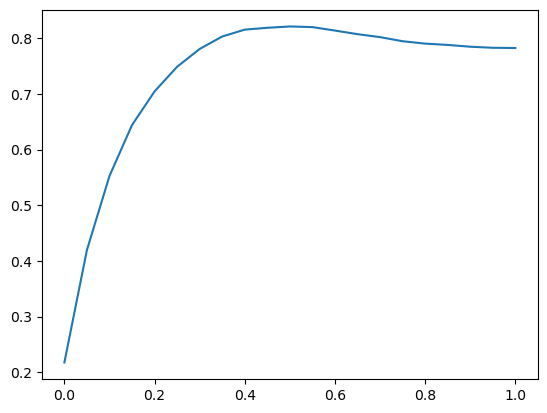

In [20]:
plt.plot(thresholds, scores)

## Model Evaluation Metrics

In [32]:
y_pred_binary = (y_pred >= 0.5).astype(int)

metrics = {
    "Accuracy": accuracy_score(y_val, y_pred_binary),
    "Precision": precision_score(y_val, y_pred_binary),
    "Recall": recall_score(y_val, y_pred_binary),
    "F1-Score": f1_score(y_val, y_pred_binary),
    "ROC-AUC": roc_auc_score(y_val, y_pred)
}

metrics_summary = (
    pd.Series(metrics, name="Score")
      .rename_axis("Metric")
      .reset_index()
)

print("Validation snapshot")
print(metrics_summary.to_string(index=False))



Validation snapshot
   Metric    Score
 Accuracy 0.820889
Precision 0.658182
   Recall 0.369388
 F1-Score 0.473203
  ROC-AUC 0.820345



CONFUSION MATRIX:
[[6664  376]
 [1236  724]]

Interpretation:
True Negatives (TN):  6664
False Positives (FP): 376
False Negatives (FN): 1236
True Positives (TP):  724


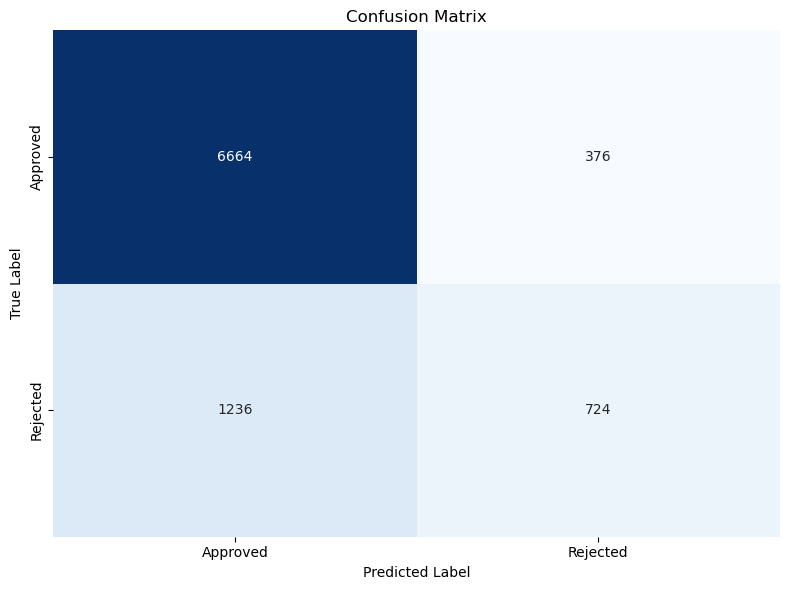

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_binary)
print("\nCONFUSION MATRIX:")
print(cm)
print("\nInterpretation:")
print(f"True Negatives (TN):  {cm[0,0]}")
print(f"False Positives (FP): {cm[0,1]}")
print(f"False Negatives (FN): {cm[1,0]}")
print(f"True Positives (TP):  {cm[1,1]}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Approved', 'Rejected'],
            yticklabels=['Approved', 'Rejected'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [23]:
print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_val, y_pred_binary, 
                           target_names=['Approved (0)', 'Rejected (1)']))



DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

Approved (0)       0.84      0.95      0.89      7040
Rejected (1)       0.66      0.37      0.47      1960

    accuracy                           0.82      9000
   macro avg       0.75      0.66      0.68      9000
weighted avg       0.80      0.82      0.80      9000



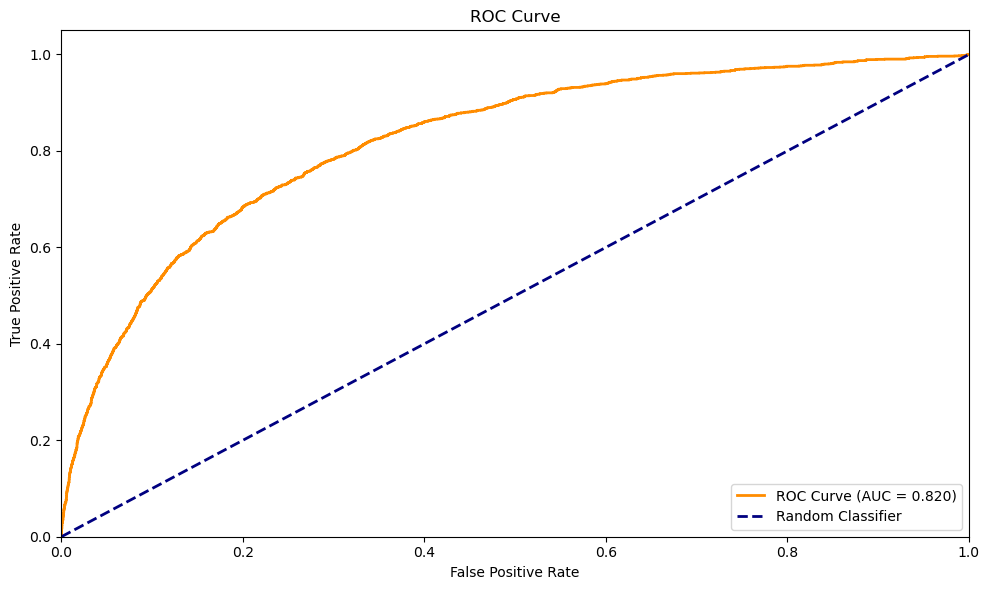

In [27]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [29]:
# For Test Data set 
test_dict = df_test[cat_cols + num_cols_for_mi].to_dict(orient='records')
X_test = dv.transform(test_dict)

y_pred_test = model.predict_proba(X_test)[:, 1]
y_pred_test_binary = (y_pred_test >= 0.5).astype(int)

lr_test_accuracy = accuracy_score(y_test, y_pred_test_binary)
lr_test_precision = precision_score(y_test, y_pred_test_binary)
lr_test_recall = recall_score(y_test, y_pred_test_binary)
lr_test_f1 = f1_score(y_test, y_pred_test_binary)
lr_test_roc_auc = roc_auc_score(y_test, y_pred_test)

print("LOGISTIC REGRESSION - TEST SET RESULTS")
print(f"Accuracy:  {lr_test_accuracy:.4f}")
print(f"Precision: {lr_test_precision:.4f}")
print(f"Recall:    {lr_test_recall:.4f}")
print(f"F1-Score:  {lr_test_f1:.4f}")
print(f"ROC-AUC:   {lr_test_roc_auc:.4f}")


LOGISTIC REGRESSION - TEST SET RESULTS
Accuracy:  0.8352
Precision: 0.7044
Recall:    0.4194
F1-Score:  0.5257
ROC-AUC:   0.8386


# Trying different models

### Random Forest Model

In [31]:
rf_model = RandomForestClassifier(n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [33]:
rf_pred_val = rf_model.predict_proba(X_val)[:, 1]
rf_pred_val_binary = (rf_pred_val >= 0.5).astype(int)

rf_val_accuracy = accuracy_score(y_val, rf_pred_val_binary)
rf_val_precision = precision_score(y_val, rf_pred_val_binary)
rf_val_recall = recall_score(y_val, rf_pred_val_binary)
rf_val_f1 = f1_score(y_val, rf_pred_val_binary)
rf_val_roc_auc = roc_auc_score(y_val, rf_pred_val)

print("RANDOM FOREST - VALIDATION SET RESULTS")
print(f"Accuracy:  {rf_val_accuracy:.4f}")
print(f"Precision: {rf_val_precision:.4f}")
print(f"Recall:    {rf_val_recall:.4f}")
print(f"F1-Score:  {rf_val_f1:.4f}")
print(f"ROC-AUC:   {rf_val_roc_auc:.4f}")

RANDOM FOREST - VALIDATION SET RESULTS
Accuracy:  0.9226
Precision: 0.8739
Recall:    0.7531
F1-Score:  0.8090
ROC-AUC:   0.9706


In [ ]:
# test set
rf_pred_test = rf_model.predict_proba(X_test)[:, 1]
rf_pred_test_binary = (rf_pred_test >= 0.5).astype(int)

rf_test_accuracy = accuracy_score(y_test, rf_pred_test_binary)
rf_test_precision = precision_score(y_test, rf_pred_test_binary)
rf_test_recall = recall_score(y_test, rf_pred_test_binary)
rf_test_f1 = f1_score(y_test, rf_pred_test_binary)
rf_test_roc_auc = roc_auc_score(y_test, rf_pred_test)

print("RANDOM FOREST - TEST SET RESULTS")
print(f"Accuracy:  {rf_test_accuracy:.4f}")
print(f"Precision: {rf_test_precision:.4f}")
print(f"Recall:    {rf_test_recall:.4f}")
print(f"F1-Score:  {rf_test_f1:.4f}")
print(f"ROC-AUC:   {rf_test_roc_auc:.4f}")

RANDOM FOREST - TEST SET RESULTS
Accuracy:  0.9273
Precision: 0.8779
Recall:    0.7740
F1-Score:  0.8227
ROC-AUC:   0.9719


### XGBoost Model

In [35]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [36]:
# Validation Dataset
xgb_pred_val = xgb_model.predict_proba(X_val)[:, 1]
xgb_pred_val_binary = (xgb_pred_val >= 0.5).astype(int)

xgb_val_accuracy = accuracy_score(y_val, xgb_pred_val_binary)
xgb_val_precision = precision_score(y_val, xgb_pred_val_binary)
xgb_val_recall = recall_score(y_val, xgb_pred_val_binary)
xgb_val_f1 = f1_score(y_val, xgb_pred_val_binary)
xgb_val_roc_auc = roc_auc_score(y_val, xgb_pred_val)

print("XGBOOST - VALIDATION SET RESULTS")
print(f"Accuracy:  {xgb_val_accuracy:.4f}")
print(f"Precision: {xgb_val_precision:.4f}")
print(f"Recall:    {xgb_val_recall:.4f}")
print(f"F1-Score:  {xgb_val_f1:.4f}")
print(f"ROC-AUC:   {xgb_val_roc_auc:.4f}")

XGBOOST - VALIDATION SET RESULTS
Accuracy:  0.9307
Precision: 0.8808
Recall:    0.7883
F1-Score:  0.8320
ROC-AUC:   0.9770


In [37]:
# On test set
xgb_pred_test = xgb_model.predict_proba(X_test)[:, 1]
xgb_pred_test_binary = (xgb_pred_test >= 0.5).astype(int)

xgb_test_accuracy = accuracy_score(y_test, xgb_pred_test_binary)
xgb_test_precision = precision_score(y_test, xgb_pred_test_binary)
xgb_test_recall = recall_score(y_test, xgb_pred_test_binary)
xgb_test_f1 = f1_score(y_test, xgb_pred_test_binary)
xgb_test_roc_auc = roc_auc_score(y_test, xgb_pred_test)


print("XGBOOST - TEST SET RESULTS")

print(f"Accuracy:  {xgb_test_accuracy:.4f}")
print(f"Precision: {xgb_test_precision:.4f}")
print(f"Recall:    {xgb_test_recall:.4f}")
print(f"F1-Score:  {xgb_test_f1:.4f}")
print(f"ROC-AUC:   {xgb_test_roc_auc:.4f}")


XGBOOST - TEST SET RESULTS
Accuracy:  0.9321
Precision: 0.8791
Recall:    0.7980
F1-Score:  0.8366
ROC-AUC:   0.9766


### Comparing All the Models

In [43]:
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [lr_test_accuracy, rf_test_accuracy, xgb_test_accuracy],
    'Precision': [lr_test_precision, rf_test_precision, xgb_test_precision],
    'Recall': [lr_test_recall, rf_test_recall, xgb_test_recall],
    'F1-Score': [lr_test_f1, rf_test_f1, xgb_test_f1],
    'ROC-AUC': [lr_test_roc_auc, rf_test_roc_auc, xgb_test_roc_auc]
})

comparison_df = comparison_df.sort_values('ROC-AUC', ascending=False).reset_index(drop=True)

print("MODEL COMPARISON - TEST SET PERFORMANCE\n")
print(comparison_df.to_string(index=False))

best_model_name = comparison_df.iloc[0]['Model']
best_roc_auc = comparison_df.iloc[0]['ROC-AUC']

print(f"\nBEST MODEL: {best_model_name} (ROC-AUC: {best_roc_auc:.4f})")


MODEL COMPARISON - TEST SET PERFORMANCE

              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
            XGBoost  0.932111   0.879146 0.797959  0.836587 0.976639
      Random Forest  0.927333   0.877894 0.773980  0.822668 0.971925
Logistic Regression  0.835222   0.704370 0.419388  0.525744 0.838603

BEST MODEL: XGBoost (ROC-AUC: 0.9766)


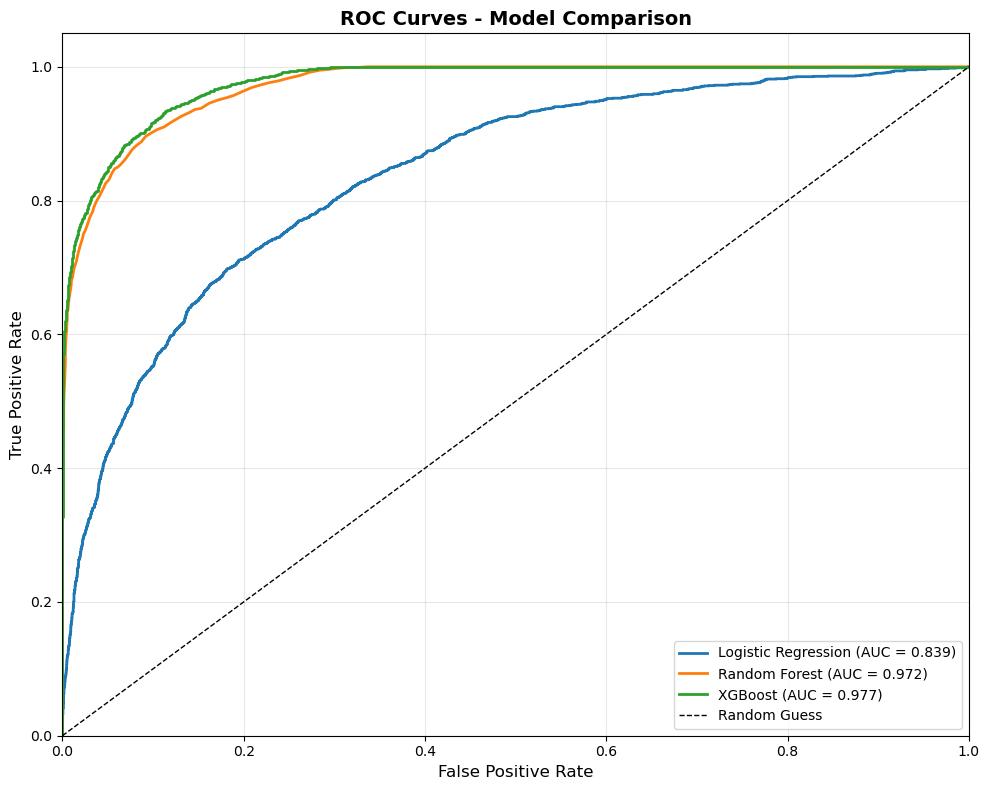

In [46]:
# ROC Curves for All Models
plt.figure(figsize=(10, 8))

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred_test)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_pred_test)

plt.plot(fpr_lr, tpr_lr, linewidth=2, label=f'Logistic Regression (AUC = {lr_test_roc_auc:.3f})')
plt.plot(fpr_rf, tpr_rf, linewidth=2, label=f'Random Forest (AUC = {rf_test_roc_auc:.3f})')
plt.plot(fpr_xgb, tpr_xgb, linewidth=2, label=f'XGBoost (AUC = {xgb_test_roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


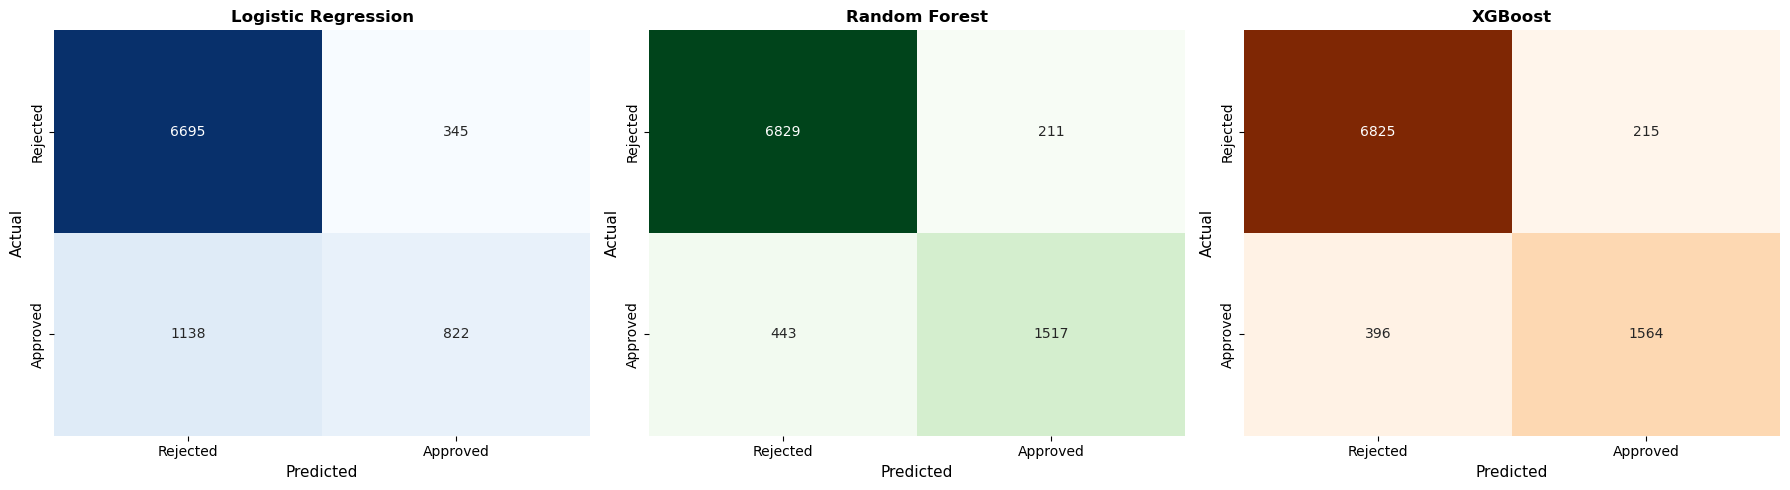

In [47]:
# Confusion matirx
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

cm_lr = confusion_matrix(y_test, y_pred_test_binary)
cm_rf = confusion_matrix(y_test, rf_pred_test_binary)
cm_xgb = confusion_matrix(y_test, xgb_pred_test_binary)

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0],
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'])
axes[0].set_title('Logistic Regression', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=11)
axes[0].set_xlabel('Predicted', fontsize=11)

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', cbar=False, ax=axes[1],
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'])
axes[1].set_title('Random Forest', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual', fontsize=11)
axes[1].set_xlabel('Predicted', fontsize=11)

sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', cbar=False, ax=axes[2],
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'])
axes[2].set_title('XGBoost', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Actual', fontsize=11)
axes[2].set_xlabel('Predicted', fontsize=11)

plt.tight_layout()
plt.show()


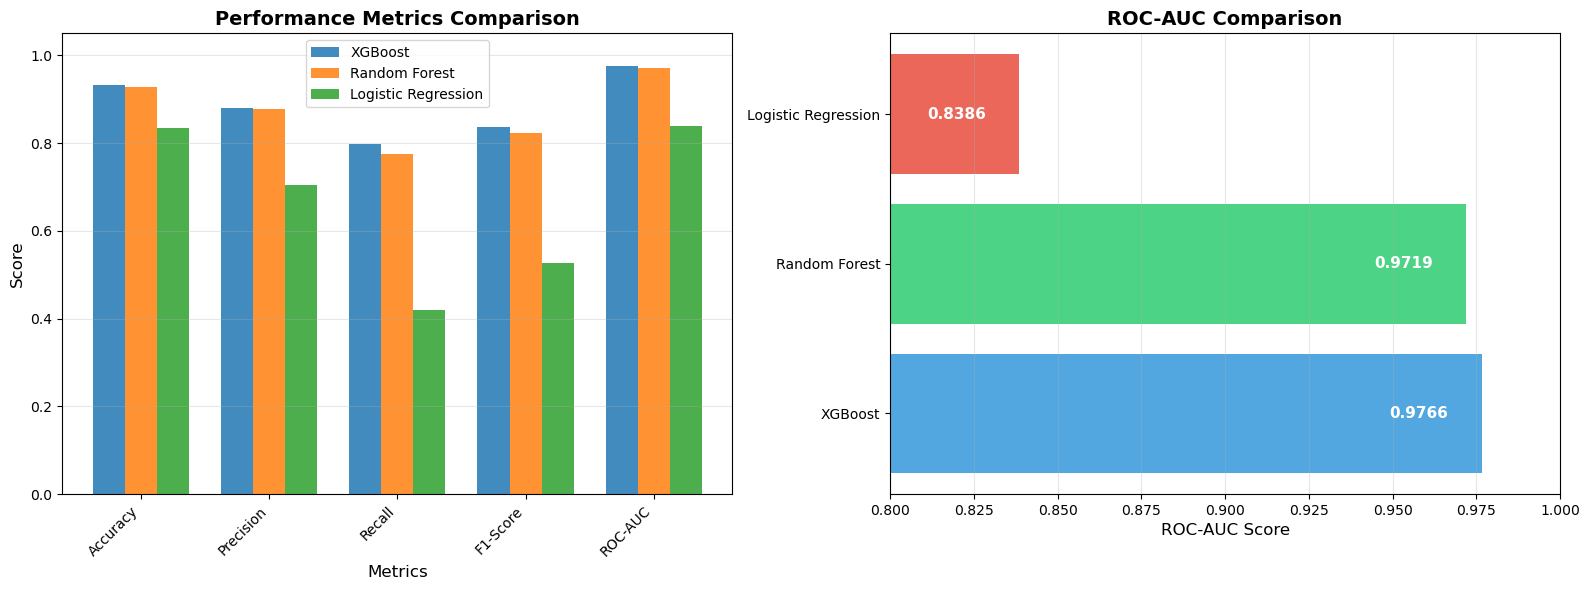

In [50]:
# final Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x_pos = np.arange(len(metrics_to_plot))
width = 0.25

for idx, model in enumerate(comparison_df['Model']):
    values = comparison_df.loc[comparison_df['Model'] == model, metrics_to_plot].values[0]
    axes[0].bar(x_pos + idx*width, values, width, label=model, alpha=0.85)

axes[0].set_xlabel('Metrics', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos + width)
axes[0].set_xticklabels(metrics_to_plot, rotation=45, ha='right')
axes[0].legend(fontsize=10)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1.05])

models = comparison_df['Model']
roc_scores = comparison_df['ROC-AUC']
colors = ['#3498db', '#2ecc71', '#e74c3c']

bars = axes[1].barh(models, roc_scores, color=colors, alpha=0.85)
axes[1].set_xlabel('ROC-AUC Score', fontsize=12)
axes[1].set_title('ROC-AUC Comparison', fontsize=14, fontweight='bold')
axes[1].set_xlim([0.80, 1.0])  
axes[1].grid(axis='x', alpha=0.3)

for bar in bars:
    width_val = bar.get_width()
    axes[1].text(width_val - 0.01, bar.get_y() + bar.get_height()/2, 
                f'{width_val:.4f}', ha='right', va='center', 
                fontweight='bold', color='white', fontsize=11)

plt.tight_layout()
plt.show()